# Step 2: Across-Datasets Analysis

In [1]:
# !pip install pandas numpy "scipy>1.12" statsmodels pingouin scikit-posthocs matplotlib seaborn adjustText

In [2]:
# binary, multiclass, multilabel_native, multilabel_powerset, all
scenario = "binary"
# significance level (used globally)
alpha = 0.05 

In [3]:
# Parameters
scenario = "multilabel_powerset"
alpha = 0.05


In [4]:
# change ~/anaconda3/Lib/site-packages/matplotlib/_mathtext.py:659
# to uniindex = 0x2D  # currency char, for lack of anything better
from matplotlib import font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths=['fonts'])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    prop = font_manager.FontProperties(fname=font_file)
    print(font_file, prop.get_name())

plt.rcParams['font.family'] = ['CMU Serif', 'DejaVu Sans']
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.unicode_minus'] = False

C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunrm.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunti.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunbx.ttf CMU Serif


In [5]:
import pandas as pd

def aggregate_metric_per_dataset(df, dataset_col='dataset', framework_col='framework', 
                                 metric_col='f1', agg_func='mean'):
    """
    Aggregates multiple trials per (dataset, framework) into a single metric.
    Drops NaN values before aggregation without modifying the original dataframe.
        
    :param df: DataFrame with columns [dataset_col, framework_col, 'Trial', metric_col, ...]
    :param dataset_col: Name of the column identifying datasets (e.g. 'dataset')
    :param framework_col: Name of the column identifying frameworks (e.g. 'framework')
    :param metric_col: Name of the metric column (e.g. 'f1' or 'training_time')
    :param agg_func: 'mean' or 'median' or any valid agg function for groupby
    :return: A new DataFrame with columns [dataset_col, framework_col, metric_col] in aggregated form.
    """
    grouped = df.dropna(subset=[metric_col]).groupby([dataset_col, framework_col], as_index=False)[metric_col].agg(agg_func)
    grouped.rename(columns={metric_col: f'{metric_col}_{agg_func}'}, inplace=True)
    return grouped

In [6]:
from pingouin import rm_anova, sphericity
from scipy.stats import friedmanchisquare
import numpy as np

def decide_test_and_run(df_agg, dataset_col='dataset', framework_col='framework', metric_col='f1_mean'):
    """
    Decide whether to do repeated-measures ANOVA or Friedman, 
    run the test, and return the results.

    Steps:
      1) Drop rows with NaN in the metric (so each dataset-framework is valid).
      2) Avoid pivoting unless needed for the test.
      3) If sphericity is okay, try repeated-measures ANOVA. Otherwise, use Friedman.
    """
    # 1) Rename columns for pingouin usage: subject=dataset, within=framework, dv=metric
    df_long = df_agg.rename(columns={
        dataset_col: 'subject',
        framework_col: 'within',
        metric_col: 'dv'
    }).copy()
    df_long.to_csv('long_1.csv')
    
    df_long.dropna(subset=['dv'], inplace=True)  # Drop missing metric values
    df_long.to_csv('long_2.csv')

    # 🚀 **Check if we have enough frameworks & subjects before pivoting**
    frameworks = df_long['within'].nunique()
    subjects = df_long['subject'].nunique()
    
    if frameworks < 2 or subjects < 2:
        return {'method': 'Not enough data'}

    # 🚀 **Check sphericity before pivoting**
    try:
        W, p_spher = sphericity(df_long, dv='dv', subject='subject', within='within')
    except Exception:
        p_spher = 0.0  # force fallback to Friedman
    
    if p_spher > alpha:
        # 🚀 **Use long format directly for rm_anova (no pivot needed!)**
        try:
            aov = rm_anova(
                data=df_long, 
                dv='dv', 
                within='within', 
                subject='subject', 
                detailed=True
            )
            pval_anova = aov.loc[0, 'p-GG-corr'] if 'p-GG-corr' in aov.columns else aov.loc[0, 'p-unc']
            
            return {
                'method': 'Repeated-Measures ANOVA',
                'anova_table': aov,
                'pval_anova': pval_anova
            }
        except Exception:
            pass  # If ANOVA fails, fallback to Friedman

    # 🚀 **Extract Data for Friedman Test Without Pivoting**
    grouped = df_long.groupby('within')['dv'].apply(list)
    grouped.to_csv('grouped_1.csv')

    # 🚀 **Ensure each framework has at least 3 subjects**
    valid_frameworks = grouped[grouped.apply(len) >= 3]  # Keep only frameworks with 3+ subjects
    
    # 🚀 **Check if we still have enough frameworks to run Friedman**
    if len(valid_frameworks) < 2:
        return {'method': 'Not enough data'}
    
    # 🚀 **Equalize sample sizes by padding with NaNs**
    max_len = max(valid_frameworks.apply(len))
    padded_data = valid_frameworks.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=np.nan))
    padded_data.to_csv('grouped_2.csv')
    
    # 🚀 **Run Friedman Test with `nan_policy='omit'`**
    data_arrays = [padded_data[fw] for fw in padded_data.index]
    fried_stat, fried_p = friedmanchisquare(*data_arrays, nan_policy='omit')

    return {
        'method': 'Friedman',
        'friedman_stat': fried_stat,
        'friedman_p': fried_p
    }

In [7]:
import scikit_posthocs as sp

def posthoc_friedman(df_agg, dataset_col='dataset', framework_col='framework', metric_col='f1_mean', method='nemenyi'):
    """
    df_agg has columns [dataset, framework, metric_col]
    Returns a post-hoc matrix of p-values.
    """
    # pivot to wide
    pivoted = df_agg.pivot(index=dataset_col, columns=framework_col, values=metric_col)
    # we can use the Nemenyi approach from scikit-posthocs
    if method == 'nemenyi':
        ph = sp.posthoc_nemenyi_friedman(pivoted)
    elif method == 'conover':
        ph = sp.posthoc_conover_friedman(pivoted)
    else:
        ph = None
    return ph

In [8]:
from pingouin import pairwise_tests

def posthoc_rm_anova(df_agg, dataset_col='dataset', framework_col='framework', metric_col='f1_mean'):
    """
    Pairwise comparisons with correction after repeated-measures ANOVA.
    """
    df_long = df_agg.rename(columns={
        dataset_col: 'subject',
        framework_col: 'within',
        metric_col: 'dv'
    })
    # pairwise_tests from pingouin
    result = pairwise_tests(
        data=df_long, 
        dv='dv', 
        within='within', 
        subject='subject', 
        padjust='holm'  # or 'bonferroni', 'fdr_bh', etc.
    )
    return result

In [9]:
import os

def plot_average_ranks(avg_ranks, title, save_path):
    fig, ax = plt.subplots()
    avg_ranks.plot(kind='barh', ax=ax)
    ax.set_ylabel("Framework")
    ax.set_xlabel("Average Rank (Lower is Better)")
    ax.set_title(title)
    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example Putting It All Together

In [10]:
def across_datasets_analysis(df, dataset_col='dataset', framework_col='framework', metric_col='f1', agg_func='mean'):
    """
    1) Aggregate trials into one metric per (dataset, framework)
    2) Decide repeated-measures ANOVA or Friedman
    3) If significant, do the relevant post-hoc
    4) Optionally compute average ranks (Friedman) or show post-hoc results
    5) Possibly produce bar chart or CD diagram
    """
    # 1) Aggregate
    df_agg = aggregate_metric_per_dataset(df, dataset_col, framework_col, metric_col, agg_func=agg_func)
    new_col_name = f"{metric_col}_{agg_func}"
    
    # Remove frameworks with missing values
    df_agg = df_agg.dropna(axis='index', subset=[new_col_name])
    
    # 2) Decide test
    test_res = decide_test_and_run(df_agg, dataset_col, framework_col, new_col_name)
    method = test_res['method']
    
    if method == 'Repeated-Measures ANOVA':
        pval_anova = test_res['pval_anova']
        print("Repeated-Measures ANOVA p-value:", pval_anova)
        if pval_anova < alpha:
            print("Significant differences => post-hoc pairwise tests")
            posthoc_res = posthoc_rm_anova(df_agg, dataset_col, framework_col, new_col_name)
            return {
                'method': method,
                'anova_result': test_res['anova_table'],
                'posthoc': posthoc_res
            }
        else:
            print("No significant difference among frameworks (p >= alpha).")
            return test_res
    
    elif method == 'Friedman':
        friedman_p = test_res['friedman_p']
        print("Friedman p-value:", friedman_p)
        if friedman_p < alpha:
            print("Significant => do Nemenyi or Conover post-hoc")
            ph = posthoc_friedman(df_agg, dataset_col, framework_col, new_col_name, method='nemenyi')
            # Example: also compute average ranks
            pivoted = df_agg.pivot(index=dataset_col, columns=framework_col, values=new_col_name)
            ascending_order = metric_col == 'training_time'  # True for time, False for F1
            ranks = pivoted.rank(axis=1, method='average', ascending=ascending_order)
            avg_ranks = ranks.mean(axis=0).sort_values()
            
            return {
                'method': method,
                'friedman_stat': test_res['friedman_stat'],
                'friedman_p': friedman_p,
                'posthoc': ph,
                'avg_ranks': avg_ranks
            }
        else:
            print("No significant difference among frameworks (p >= alpha).")
            return test_res
    else:
        print("Not enough data or sphericity test/ANOVA failed.")
        return test_res

In [11]:
def print_formatted_result(k, v):
    if k == 'posthoc':
        print(f'  {k}:')
        display(v)
    elif k == 'avg_ranks':
        print(f'  {k}:')
        display(v.to_frame(name='avg_rank'))
    else:
        print(f"  {k}: {v}")

In [12]:
# ========================
# ====== MAIN CALL =======
# ========================

# Example CSV structure: dataset, framework, trial, f1, training_time
# e.g., "31,autogluon,1,0.6949,8.6927"
df = pd.read_csv(f"stats/{scenario}/experimental_results.csv")
df = df.rename(columns={
    'Dataset': 'dataset', 
    'Dataset Type': 'type', 
    'Framework': 'framework', 
    'Trial': 'trial', 
    'F1 Score': 'f1', 
    'Training Time': 'training_time'}
)

In [13]:
res_f1 = across_datasets_analysis(df, metric_col='f1', agg_func='mean')

print("\nF1 Analysis:")
for k, v in res_f1.items():
    print_formatted_result(k, v)

Friedman p-value: 0.0017407481326388548
Significant => do Nemenyi or Conover post-hoc

F1 Analysis:
  method: Friedman
  friedman_stat: 31.35164835164835
  friedman_p: 0.0017407481326388548
  posthoc:


C:\Users\marce\anaconda3\lib\site-packages\pandas\core\frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marce\anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\marce\anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000,0.997655,0.097731,0.021361,1.000000,1.000000,0.956155,0.432978,0.057488,0.806464,0.000544,0.082339,0.977307,0.999573,0.642149
autogluon,0.997655,1.000000,0.809358,0.469554,0.999998,0.997655,1.000000,0.992670,0.692784,0.999975,0.055738,0.773206,1.000000,1.000000,0.999406
autokeras,0.097731,0.809358,1.000000,1.000000,0.349737,0.097731,0.968042,0.999998,1.000000,0.997757,0.989506,1.000000,0.941295,0.699830,0.999835
autopytorch,0.021361,0.469554,1.000000,1.000000,0.115345,0.021361,0.779441,0.998521,1.000000,0.945306,0.999902,1.000000,0.699830,0.349737,0.986244
autosklearn,1.000000,0.999998,0.349737,0.115345,1.000000,1.000000,0.999185,0.815079,0.241750,0.982765,0.005545,0.311234,0.999788,1.000000,0.935627
evalml,1.000000,0.997655,0.097731,0.021361,1.000000,1.000000,0.956155,0.432978,0.057488,0.806464,0.000544,0.082339,0.977307,0.999573,0.642149
flaml,0.956155,1.000000,0.968042,0.779441,0.999185,0.956155,1.000000,0.999902,0.923162,1.000000,0.183107,0.956155,1.000000,0.999999,0.999999
gama,0.432978,0.992670,0.999998,0.998521,0.815079,0.432978,0.999902,1.000000,0.999957,1.000000,0.779441,0.999994,0.999573,0.977307,1.000000
h2o,0.057488,0.692784,1.000000,1.000000,0.241750,0.057488,0.923162,0.999957,1.000000,0.990554,0.997438,1.000000,0.876300,0.567255,0.998781
lightautoml,0.806464,0.999975,0.997757,0.945306,0.982765,0.806464,1.000000,1.000000,0.990554,1.000000,0.400909,0.996237,1.000000,0.999746,1.000000


  avg_ranks:


,avg_rank
framework,
4intelligence,1.571429
autosklearn,2.857143
evalml,4.000000
pycaret,4.000000
autogluon,4.833333
naive,5.142857
flaml,5.428571
lightautoml,7.250000
tpot,7.333333


In [14]:
undesired_columns = ['posthoc', 'avg_ranks']

res_f1_filtered = {k: v if k not in undesired_columns else None for k,v in res_f1.items()}

res_f1_df = pd.DataFrame.from_dict(res_f1_filtered, orient='index').T.drop(columns=undesired_columns)
res_f1_df['significant'] = res_f1_df['friedman_p'] < alpha

res_f1_df.to_csv(f"stats/{scenario}/step_2_across_datasets_stat_results_f1.csv")
res_f1_df

,method,friedman_stat,friedman_p,significant
0,Friedman,31.351648,0.001741,True


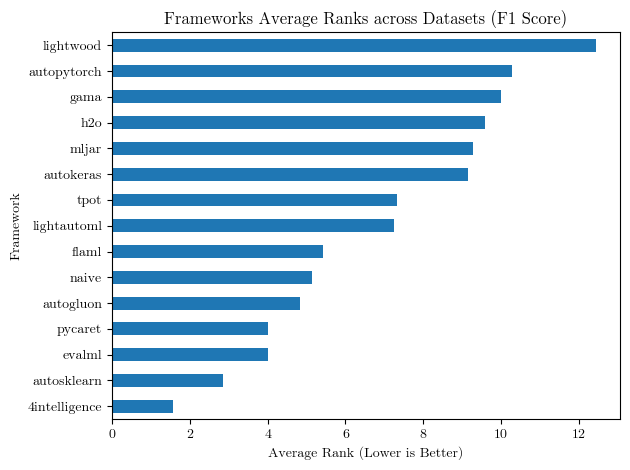

In [15]:
plot_average_ranks(
    res_f1['avg_ranks'],
    "Frameworks Average Ranks across Datasets (F1 Score)",
    save_path=f"stats/{scenario}/step_2_across_datasets_avg_ranks_f1.png"
)

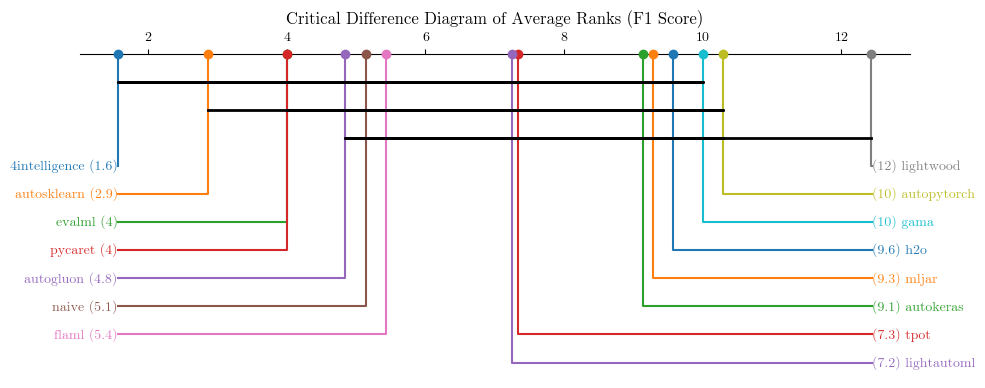

In [16]:
# https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.critical_difference_diagram.html
plt.figure(figsize=(10, 4))
plt.title('Critical Difference Diagram of Average Ranks (F1 Score)')
sp.critical_difference_diagram(ranks=res_f1['avg_ranks'], sig_matrix=res_f1['posthoc'])
plt.tight_layout()
plt.savefig(f"stats/{scenario}/step_2_across_datasets_cd_diagram_f1.png", dpi=300)

In [17]:
res_time = across_datasets_analysis(df, metric_col='training_time', agg_func='median')

print("\nTime Analysis:")
for k, v in res_time.items():
    print_formatted_result(k, v)

Friedman p-value: 0.0001567691277029516
Significant => do Nemenyi or Conover post-hoc

Time Analysis:
  method: Friedman
  friedman_stat: 37.94505494505495
  friedman_p: 0.0001567691277029516
  posthoc:


C:\Users\marce\anaconda3\lib\site-packages\pandas\core\frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\marce\anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\marce\anaconda3\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,4intelligence,autogluon,autokeras,autopytorch,autosklearn,evalml,flaml,gama,h2o,lightautoml,lightwood,mljar,naive,pycaret,tpot
4intelligence,1.000000,0.773206,0.115345,1.000000,0.999788,1.000000,0.999573,0.815079,1.000000,0.815079,0.021361,0.476965,0.815079,0.999998,0.999914
autogluon,0.773206,1.000000,0.999265,0.734195,0.999096,0.692784,0.999522,1.000000,0.871741,1.000000,0.958334,1.000000,1.000000,0.305049,0.183107
autokeras,0.115345,0.999265,1.000000,0.097731,0.699830,0.082339,0.740877,0.998521,0.183107,0.998521,1.000000,0.999998,0.998521,0.013884,0.005769
autopytorch,1.000000,0.734195,0.097731,1.000000,0.999573,1.000000,0.999185,0.779441,1.000000,0.779441,0.017263,0.432978,0.779441,0.999999,0.999963
autosklearn,0.999788,0.999096,0.699830,0.999573,1.000000,0.999185,1.000000,0.999573,0.999983,0.999573,0.311234,0.977307,0.999573,0.956155,0.880759
evalml,1.000000,0.692784,0.082339,1.000000,0.999185,1.000000,0.998521,0.740877,1.000000,0.740877,0.013884,0.390431,0.740877,1.000000,0.999985
flaml,0.999573,0.999522,0.740877,0.999185,1.000000,0.998521,1.000000,0.999788,0.999957,0.999788,0.349737,0.984332,0.999788,0.941295,0.852501
gama,0.815079,1.000000,0.998521,0.779441,0.999573,0.740877,0.999788,1.000000,0.901537,1.000000,0.941295,1.000000,1.000000,0.349737,0.215974
h2o,1.000000,0.871741,0.183107,1.000000,0.999983,1.000000,0.999957,0.901537,1.000000,0.901537,0.039288,0.612430,0.901537,0.999957,0.999265
lightautoml,0.815079,1.000000,0.998521,0.779441,0.999573,0.740877,0.999788,1.000000,0.901537,1.000000,0.941295,1.000000,1.000000,0.349737,0.215974


  avg_ranks:


,avg_rank
framework,
lightwood,1.000000
autokeras,2.285714
mljar,3.857143
autogluon,4.833333
gama,5.000000
lightautoml,5.000000
naive,5.000000
flaml,7.285714
autosklearn,7.428571


In [18]:
undesired_columns = ['posthoc', 'avg_ranks']

res_time_filtered = {k: v if k not in undesired_columns else None for k,v in res_time.items()}

res_time_df = pd.DataFrame.from_dict(res_time_filtered, orient='index').T.drop(columns=undesired_columns)
res_time_df['significant'] = res_time_df['friedman_p'] < alpha

res_time_df.to_csv(f"stats/{scenario}/step_2_across_datasets_stat_results_time.csv")
res_time_df

,method,friedman_stat,friedman_p,significant
0,Friedman,37.945055,0.000157,True


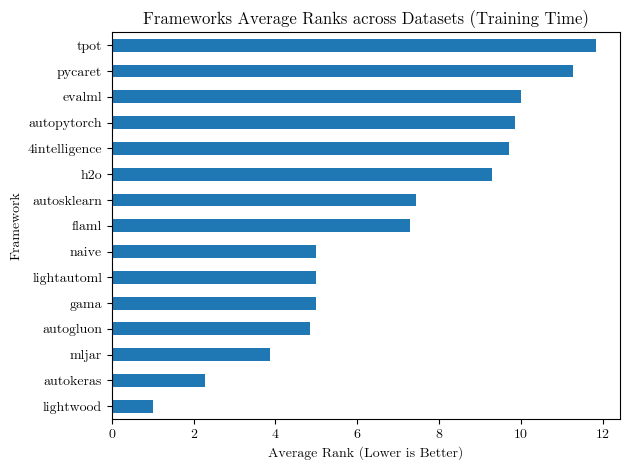

In [19]:
plot_average_ranks(
    res_time['avg_ranks'],
    "Frameworks Average Ranks across Datasets (Training Time)",
    save_path=f"stats/{scenario}/step_2_across_datasets_avg_ranks_time.png"
)

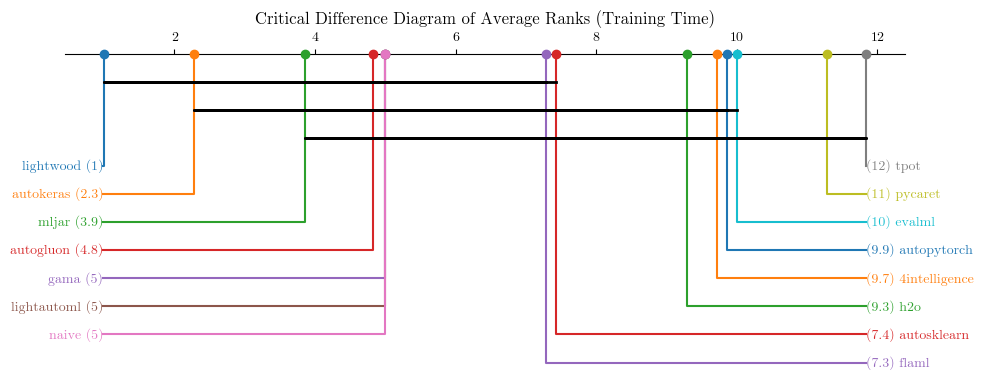

In [20]:
# https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.critical_difference_diagram.html
plt.figure(figsize=(10, 4))
plt.title('Critical Difference Diagram of Average Ranks (Training Time)')
sp.critical_difference_diagram(ranks=res_time['avg_ranks'], sig_matrix=res_time['posthoc'])
plt.tight_layout()
plt.savefig(f"stats/{scenario}/step_2_across_datasets_cd_diagram_time.png", dpi=300)

In [21]:
# Suppose you already computed avg_ranks_f1 and avg_ranks_time as Pandas Series:
#   - Index = framework name
#   - Values = average rank
# Combine them
df_ranks = pd.DataFrame({
    'Framework': res_f1['avg_ranks'].index,
    'Rank_F1': res_f1['avg_ranks'].values,
    'Rank_Time': res_time['avg_ranks'][res_f1['avg_ranks'].index].values  # align same frameworks
})

# Sort optionally by Rank_F1
df_ranks.sort_values(by='Rank_F1', inplace=True)

# Display the table
df_ranks.to_csv(f"stats/{scenario}/step_2_across_datasets_dual_ranks.csv")
df_ranks

,Framework,Rank_F1,Rank_Time
0,4intelligence,1.571429,9.714286
1,autosklearn,2.857143,7.428571
2,evalml,4.000000,10.000000
3,pycaret,4.000000,11.285714
4,autogluon,4.833333,4.833333
5,naive,5.142857,5.000000
6,flaml,5.428571,7.285714
7,lightautoml,7.250000,5.000000
8,tpot,7.333333,11.833333
9,autokeras,9.142857,2.285714


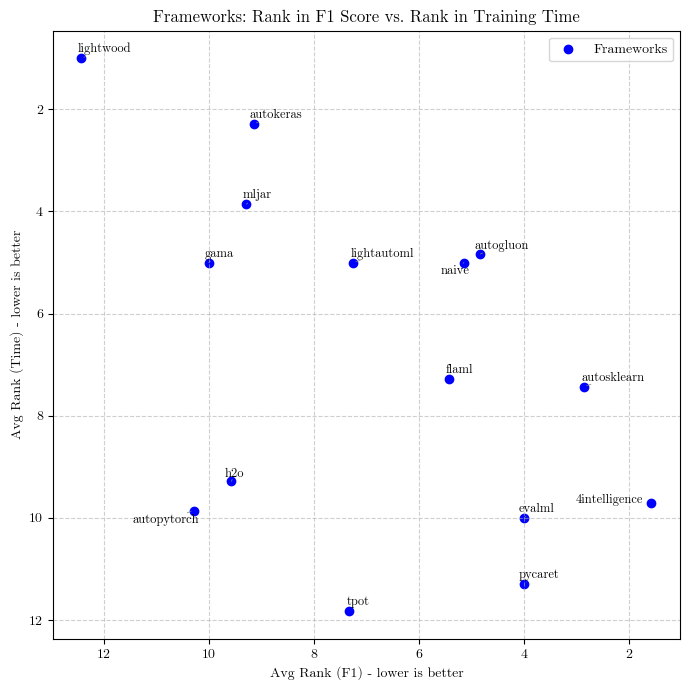

In [22]:
from adjustText import adjust_text

plt.figure(figsize=(7, 7))
plt.scatter(df_ranks['Rank_F1'], df_ranks['Rank_Time'], color='blue', label="Frameworks")

# Create text labels
texts = []
for i, row in df_ranks.iterrows():
    text = plt.text(
        row['Rank_F1'], row['Rank_Time'], row['Framework'], 
        ha='center', va='center', fontsize=9
    )
    texts.append(text)

# Automatically adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Labels & Titles
plt.xlabel("Avg Rank (F1) - lower is better")
plt.ylabel("Avg Rank (Time) - lower is better")
plt.title("Frameworks: Rank in F1 Score vs. Rank in Training Time")

# Optional axis inversion
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig(f"stats/{scenario}/step_2_across_datasets_dual_ranks_clean.png", dpi=300)
plt.show()

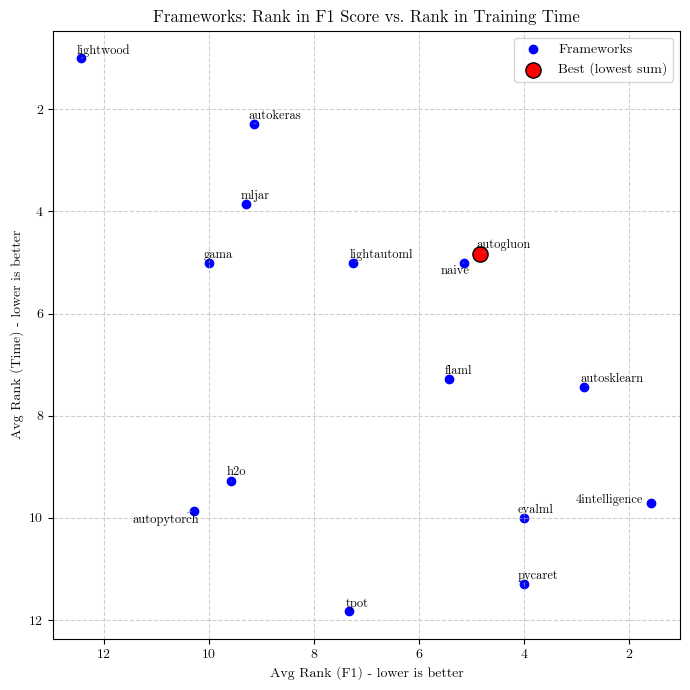

In [23]:
from adjustText import adjust_text

# Suppose df_ranks has columns: [Framework, Rank_F1, Rank_Time]
# 1) Compute sum of ranks for each framework
df_ranks['Rank_Sum'] = df_ranks['Rank_F1'] + df_ranks['Rank_Time']

# 2) Find the "best" framework => minimal total rank
best_idx = df_ranks['Rank_Sum'].idxmin()
best_fw_row = df_ranks.loc[best_idx]  # row data

plt.figure(figsize=(7, 7))

# 3) Plot all frameworks in blue
plt.scatter(df_ranks['Rank_F1'], df_ranks['Rank_Time'], color='blue', label="Frameworks")

# 4) Highlight the best framework in red
plt.scatter(best_fw_row['Rank_F1'], best_fw_row['Rank_Time'],
            color='red', s=120, edgecolor='k', label="Best (lowest sum)")

# Create text labels
texts = []
for i, row in df_ranks.iterrows():
    text = plt.text(
        row['Rank_F1'], row['Rank_Time'], 
        row['Framework'], ha='center', va='center', fontsize=9
    )
    texts.append(text)

# Automatically adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Labels & Titles
plt.xlabel("Avg Rank (F1) - lower is better")
plt.ylabel("Avg Rank (Time) - lower is better")
plt.title("Frameworks: Rank in F1 Score vs. Rank in Training Time")

# Optional axis inversion
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig(f"stats/{scenario}/step_2_across_datasets_dual_ranks_marked.png", dpi=300)
plt.show()